# Assignment 2


*Please fill out the relevant cells below according to the instructions. When done, save the notebook and export it to PDF, upload both the `ipynb` and the PDF file to Canvas.*

## Group Members

*Group submission is highly encouraged. If you submit as part of group, list all group members here. Groups can comprise up to 5 students.*

* Adam Applegate
* Beatrix Brahms
* 

---

## Problem 2: Clustering Hyper-Spectral Images (3pts)

Hyper-spectral images of a scene are recorded in hundreds of wavelengths, typically extending beyond the range perceptible by humans. They play a critical role in remote sensing from aerial and satellite platforms because they allow us to infer e.g. where roads or vegetation are (even under clouds), how well crops grow, the salinity of water...

Often, you don't know a priori what is recorded in a particular hyper-spectral data set. Unsupervised clustering is then a way to identify interesting structures. Download [this](https://github.com/fred3m/hyperspectral/blob/master/data/subset.npy) hyper-spectral data set, [taken from an airplane](https://doi.org/10.1117/12.157055) flying over Capitol Hill in Washington, D.C. It consists of 191 spectral channels, each having 200 x 200 pixels. Then pick 2 different clustering algorithms and attempt to identify interesting structures. This will typically require some tinkering with parameter settings. When done, compare what the two clustering algorithms found and try to explain why the outcomes differ on the basis of the assumptions made by the algorithms.

**Hint:** The data are stored in the layout `(N_channels, N_pixels)`, with each 2D image flattened into a single long vector. This treats every channel as an independent sample with a vector of intensity variations per pixel. Alternatively, you can flip the axes into the layout `(N_pixels, N_channels)`, which treat every pixel as an independent sample with a vector of intensity variations per channel. Both of these are valid, as are hybrids and subsets. Decide which of them you want to use.

**Hint 2:** For visualization, it's best to reshape the pixel vector from `(N_pixels)` to `(N_pixels_vertical, N_pixels_horizontal)`. Also, Google Maps/Earth could turn out to be useful.

# Problem 2: Solution

We start off by loading the data and plotting a couple of pictures corresponding to random channels to get a sense of the data set. When working with the data, we work in the format `(N_channels, N_pixels)` and interpret each pixel vector as an observation.

Text(0.5, 0.98, 'Pictures corresponding to 16 random channels')

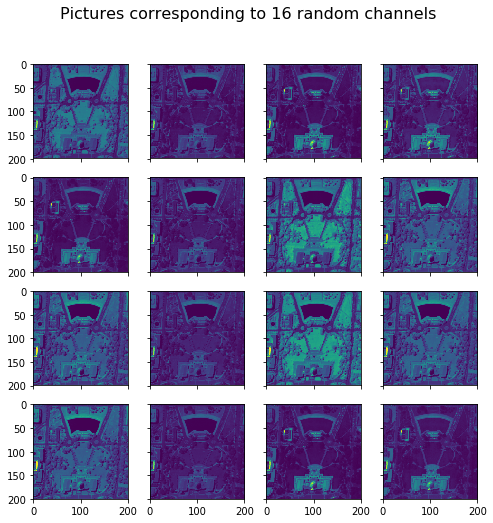

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

#############################################
#Load data
#############################################

X = np.load("subset.npy")


#############################################
#print random images
#############################################

fig, axes = plt.subplots(4, 4, figsize=(8, 8), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    ax.imshow(X[int(X.shape[0]*np.random.uniform(0,1)),:].reshape((200,200)))
fig.suptitle('Pictures corresponding to 16 random channels', fontsize=16)

### Mean shift with dimensionality reduction

We apply mean shift in combination with dimensionality reduction. For dimensionality reduction, we use PCA. We apply mean shift on the PCA projected data set in order to overcome the curse of dimensionality. THat is, each observation (which is in our case a picture) has 200x200 = 40000 dimensions (one corresponding to each pixel). Therefore, we observe that the data is very high dimension. Mean shift works with kernel denisity estimators which only work reliably and stable for low dimensions. Therefore, we are using PCA to reduce the 40000 dimensions to $d = 3$ dimensions. The underlying assumption is therefore that the first 3 dimensions exlain enough of the sample variance. 

To kick things off, we fist standardize the data.

In [2]:
#############################################
#Mean Shift + PCA
#############################################

from sklearn.preprocessing import StandardScaler

####################
#standardize data
####################

scaler = StandardScaler(with_mean = True, with_std = True)
scaler.fit(X)
Y = scaler.transform(X)

Next, we apply PCA with $d = 3$ dimensions.

In [3]:
####################
#apply PCA
####################

from sklearn.decomposition import PCA

#number of PCs 
N_pca = 3
pca = PCA(n_components=N_pca)
pca.fit(Y)

#calculation of PCs
Y = pca.transform(Y)

#PCA reconstructions
X_rec = scaler.inverse_transform(pca.inverse_transform(Y))

We proceed to gauge the quality of our PCA reduction. First, we look at the explained variance ratio plot. 

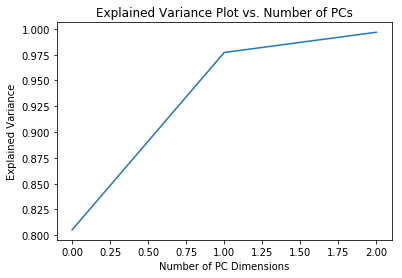

In [4]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of PC Dimensions")
plt.ylabel("Explained Variance")
plt.title("Explained Variance Plot vs. Number of PCs")
plt.show()

We observe that all three PCs explain almost all in-sample variance of the data set. This indicates that most of the information of the full 200x200 pixel data set can be explained by only 3 dimensions. Now, we compare a couple of original pictures with their PCA reconstructions. 

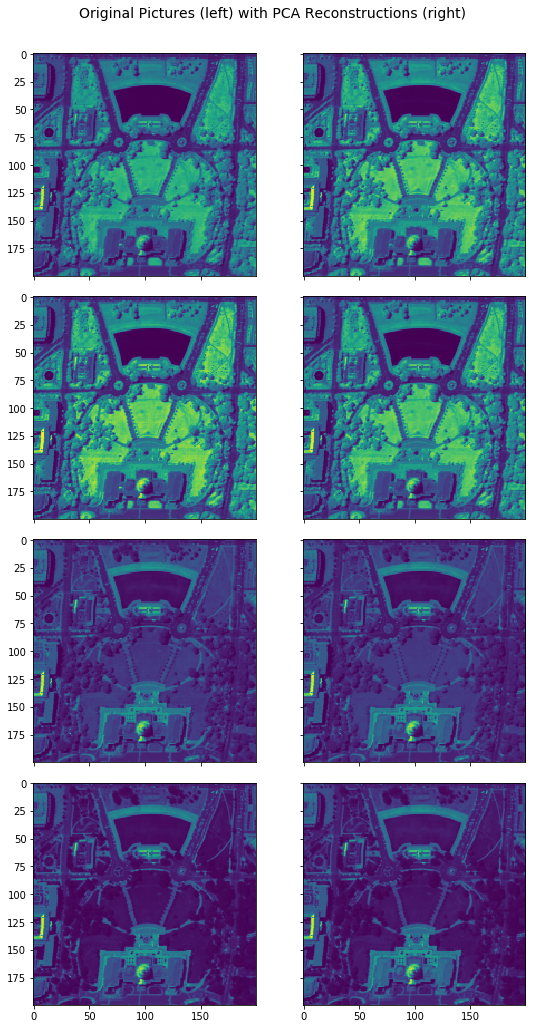

In [5]:
####################
#Comparing original pictures with PCA reconstructions
####################

fig, axes = plt.subplots(4, 2, figsize=(8, 15), sharex=True, sharey=True)
for i, ax in enumerate(axes):
    j = int(X.shape[0]*np.random.uniform(0,1))
    ax[0].imshow(X[j,:].reshape((200,200)))
    ax[1].imshow(X_rec[j,:].reshape((200,200)))
fig.suptitle('Original Pictures (left) with PCA Reconstructions (right)', fontsize=14)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

We see that in most cases, the PCA reconstruction is very similar to the original pictures. This and the explained variance plot indicate that PCA with 3 dimensions works well on this data set and captures most of the information.

Next, we apply the mean shift algorithm with different bandwidths on the data set of PCs, i.e. the data set after dimensionality reductions. We then transform the resulting clusters back to the original data space in order to plot the result. 

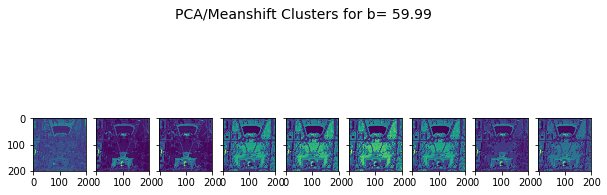

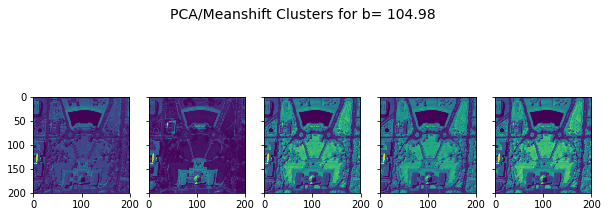

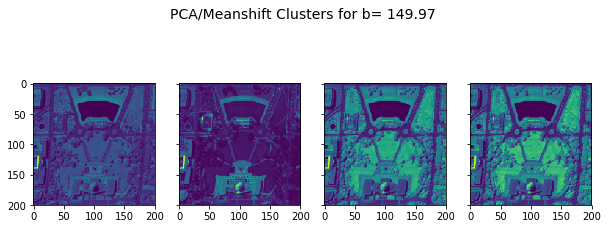

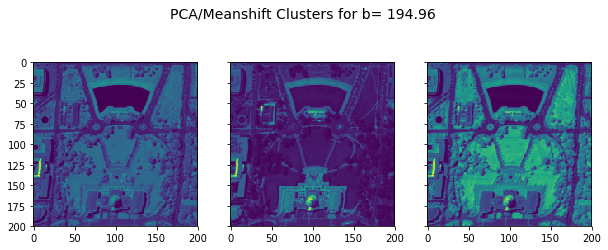

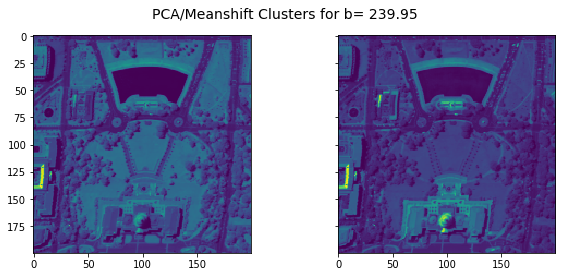

In [6]:
####################
#Apply meanshift to PCs
####################

from sklearn.cluster import MeanShift, estimate_bandwidth

est_bandwidth = estimate_bandwidth(Y)
bs= np.linspace(0.5*est_bandwidth, 2.0*est_bandwidth, 5)
N_centers = np.zeros(len(bs))

for i in range(len(bs)):    
    
    ms = MeanShift(bandwidth=bs[i])
    ms.fit(Y)
    centers = scaler.inverse_transform(pca.inverse_transform(ms.cluster_centers_))
    N_centers[i] = int(centers.shape[0])
    fig, axes = plt.subplots(1, int(N_centers[i]), figsize=(10, 4), sharex=True, sharey=True)
    for j,ax in enumerate(axes):
        ax.imshow(centers[j,:].reshape((200,200)))
    fig.suptitle('PCA/Meanshift Clusters for b= '+str(round(bs[i],2)), fontsize=14)
    plt.show()

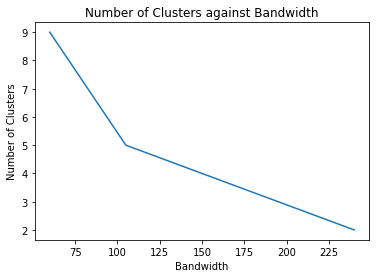

In [7]:
plt.figure(2)
plt.plot(bs, N_centers)
plt.xlabel("Bandwidth")
plt.ylabel("Number of Clusters")
plt.title("Number of Clusters against Bandwidth")
plt.show()

## Hierarchical Clustering
Having located clusters in *color* space, we now proceed to finding "clusters" or "features" (e.g. roads, trees, monuments) in the principal component images. These principal components can be thought of as fancily-binned images in frequency space.